In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date


In [2]:
# Define the ticker symbol
tickerSymbol = 'USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-19 00:00:00-04:00,132.779999,137.419998,105.330002,113.510002,4394200,0.0,0.0,0.0
2024-07-26 00:00:00-04:00,119.629997,124.029999,100.349998,105.529999,5121200,0.0,0.0,0.0
2024-08-02 00:00:00-04:00,95.129997,101.379997,76.000000,96.930000,5997500,0.0,0.0,0.0
2024-08-09 00:00:00-04:00,96.110001,124.669998,93.879997,123.750000,3512500,0.0,0.0,0.0
2024-08-16 00:00:00-04:00,121.959999,126.169998,120.550003,125.500000,461400,0.0,0.0,0.0


In [3]:
max_weeks = 52

In [15]:

gap = (1/90)*100

option_prices = {
    # 1: [94/1.95], # too high 4k%
    2: [90/4.05],
    3: [91/5.15],
    4: [81/5.4, 74/5.1],
    5: [100/7.05, 126/12.05],
    6: [94/7.4],
    7: [90/8.25],
    8: [91/8.05],
    9: [81/8.45, 100/9.4, 126/15.6],
    13: [100/11.5, 126/19.2],
    14: [94/10.55],
    15: [90/11.15],
    16: [91/12.75],
    17: [81/11.3, 74/10.4],
    26: [100/18.55],
    27: [94/17.25, 126/26.35],
    28: [90/16.9],
    29: [91/17.55],
    30: [81/14.95]
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
option_leverage |= {
 1: 39.78571428571429,
 2: 26.896551724137932,
 3: 19.767441860465116,
 4: 18.01948051948052,
 5: 15.074595055413472,
 6: 13.310023310023311,
 7: 13.772609819121445,
 8: 10.511111111111111}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

option leverages:
	 2w 22.2
	 3w 17.7
	 4w 15.0 14.5
	 5w 14.2 10.5
	 6w 12.7
	 7w 10.9
	 8w 11.3
	 9w  9.6 10.6  8.1
	13w  8.7  6.6
	14w  8.9
	15w  8.1
	16w  7.1
	17w  7.2  7.1
	26w  5.4
	27w  5.4  4.8
	28w  5.3
	29w  5.2
	30w  5.4
mean option leverage, break even:
	 1w 39.8  3.6%
	 2w 26.9  4.8%
	 3w 19.8  6.2%
	 4w 18.0  6.7%
	 5w 15.1  7.7%
	 6w 13.3  8.6%
	 7w 13.8  8.4%
	 8w 10.5 10.6%
	 9w  9.4 11.7%
	13w  7.6 14.2%
	14w  8.9 12.3%
	15w  8.1 13.5%
	16w  7.1 15.1%
	17w  7.1 15.1%
	26w  5.4 19.7%
	27w  5.1 20.7%
	28w  5.3 19.9%
	29w  5.2 20.4%
	30w  5.4 19.6%
option gap: 1.11%


In [5]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [6]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 1w   51%  39%   -8%
	 2w   70%  44%   25%
	 3w   66%  42%   16%
	 4w   81%  44%   25%
	 5w   79%  42%   16%
	 6w   81%  43%   10%
	 7w  107%  47%   43%
	 8w   73%  45%    2%
	 9w   79%  47%   15%
	13w  110%  53%   50%
	14w  129%  56%   76%
	15w  120%  55%   65%
	16w  108%  53%   42%
	17w  120%  53%   66%
	26w  161%  59%  103%
	27w  174%  59%  129%
	28w  179%  57%  126%
	29w  182%  61%  146%
	30w  206%  61%  167%


In [7]:
from file import save_file

save_file(tickerSymbol, option_performance)

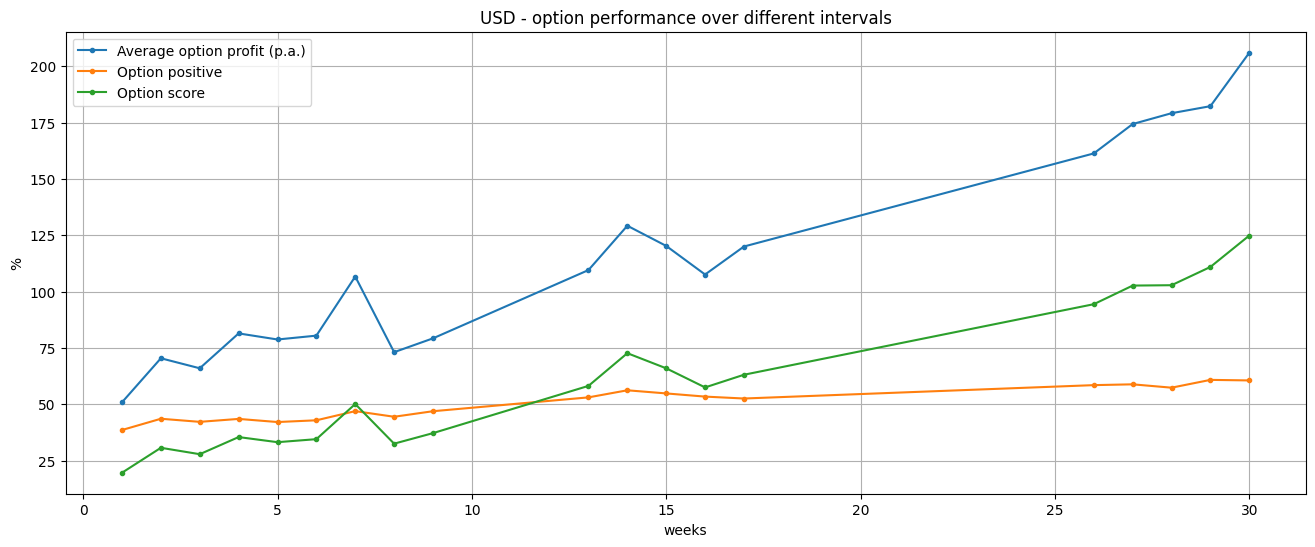

In [8]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit (p.a.)', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

In [9]:
weeks = 4
history['stock_change'] = history['Close'].pct_change(periods=weeks) * 100
history['whigh'] = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
lvr = option_leverage[weeks]
history['wmax_profit'] = (((history['whigh'] / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)


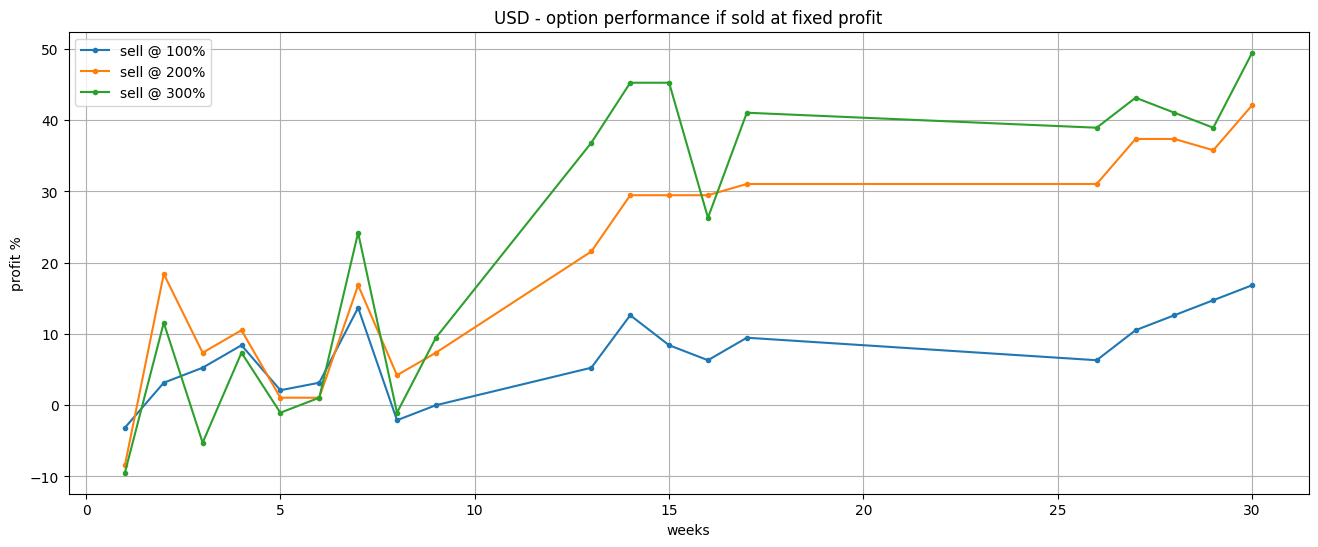

In [10]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in range(1, max_weeks+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

        if weeks in option_leverage:
            lvr = option_leverage[weeks]
            wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
            q = (wmax >= percent).mean()
            data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

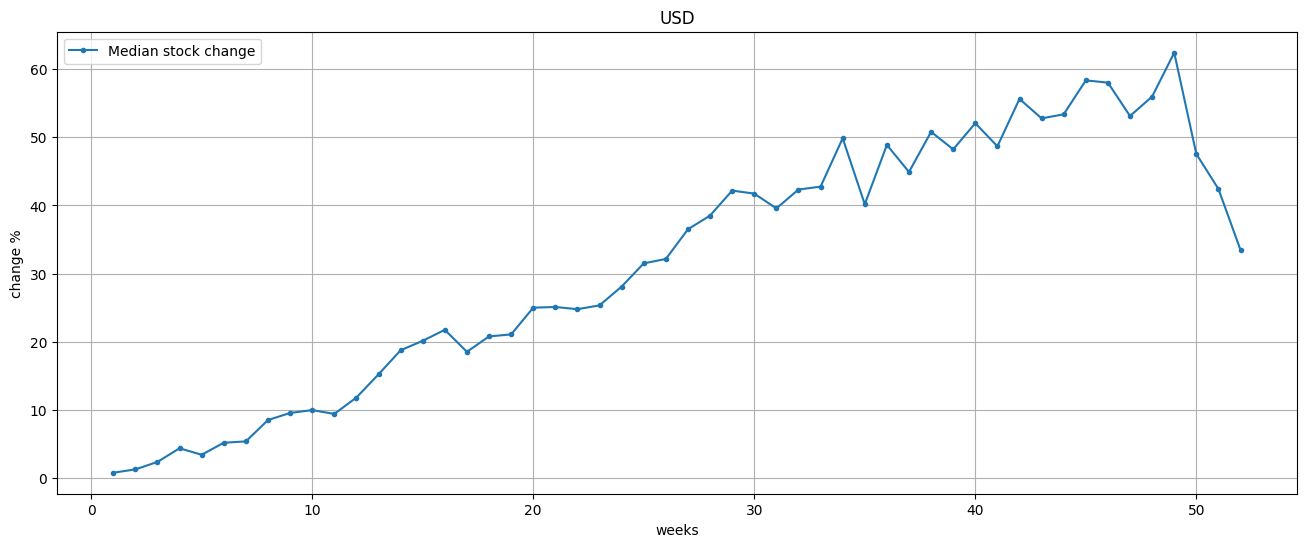

In [11]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


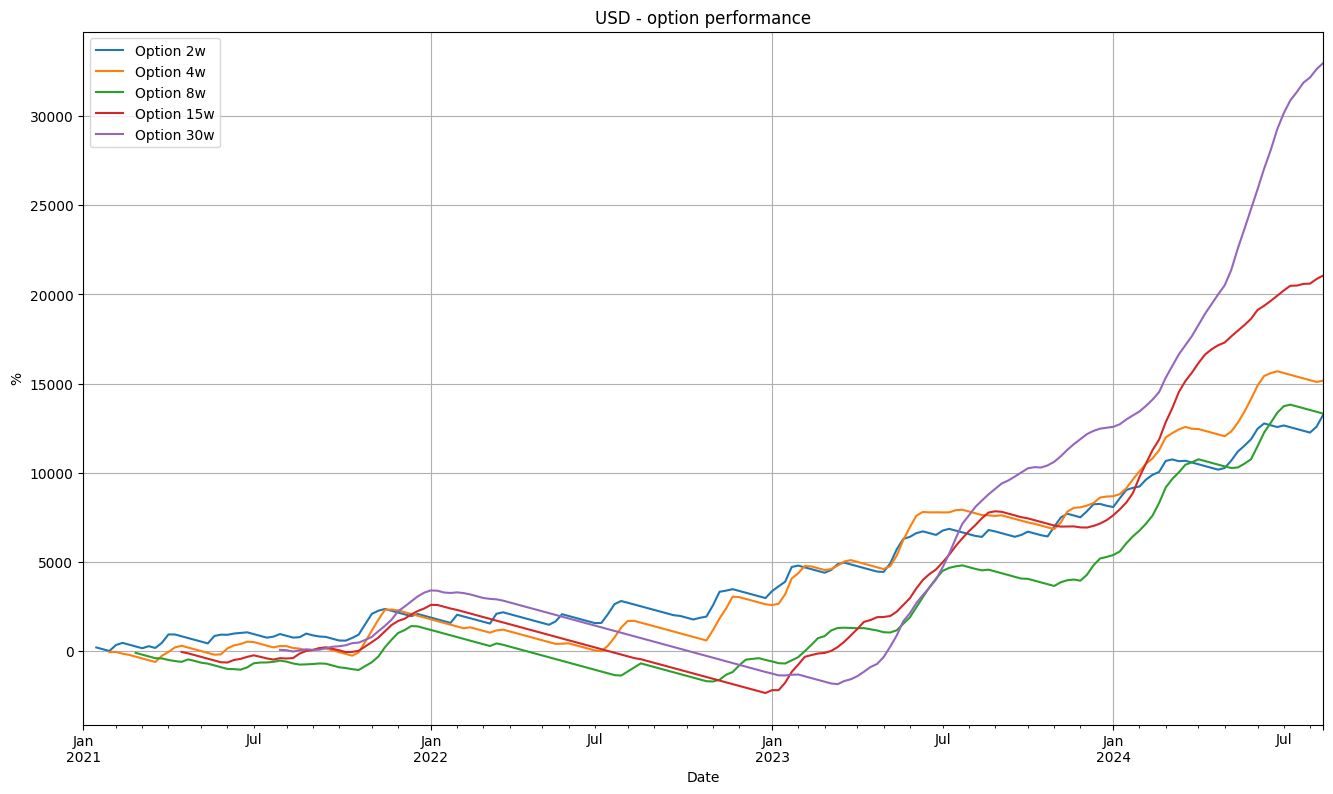

In [12]:
plt.figure(figsize=(16,9))

for w in [2,4,8,15,30]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


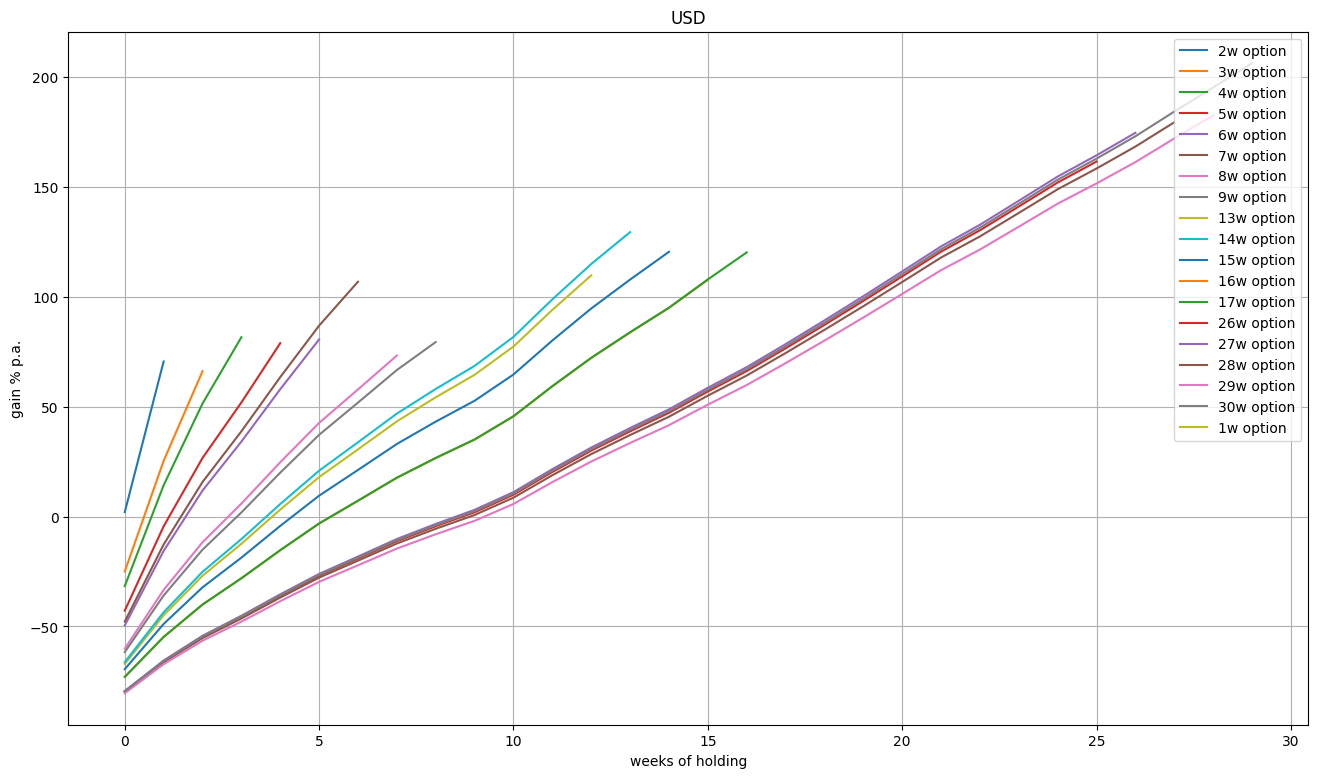

In [13]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()